# Gridding the satellite data

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath

import numpy as np
import geopandas

from shapely.geometry import Point
from shapely.geometry import Polygon

import xesmf as xe

import os

In [2]:
#import data (polygons describing the Arctic sea ice, monthly means for September)
SIpolys = []
for k,i in enumerate(range(1979,2022)):
    zipfile = "zip:///media/clara/Seagate/Satellite_ASI_data/Sea_Ice_Index/extent_N_{}09_polygon_v3.0.zip".format(i)
    SIpoly = geopandas.read_file(zipfile)
    SIpolys.append(SIpoly)    

In [3]:
years = range(1979,2022)

In [4]:
#define area, boundary and exterior as attributes of the polygones for each September
for i, poly in enumerate(SIpolys):
    poly["area"] = poly.area
    poly["boundary"] = poly.boundary
    poly["exterior"] = poly.exterior
    main_id = np.argmax(poly.area)


Define a 0.5 degree grid:

In [5]:
#create xarray with lat/lon grid and time axis, 0 siconc for now
gridding = 0.5 
ds = xe.util.grid_global(gridding, gridding).copy()
ds_in = ds.assign(siconc = lambda x: x.lon*0.0).copy()
ds_sat = ds_in.expand_dims({"t":years}).copy()

simplify the shape and keep only the biggest sea ice chunk (by area, called "bigblob" here) for every September

In [6]:
SIpolys_bigblob = np.zeros_like(SIpolys)

for i,ww in enumerate(SIpolys):
    bigblob = ww.iloc[[np.argmax((ww.area))]]
    shapes = bigblob

    min_grid_size = float(min(abs(ds_in.lat.diff('lat')).min(), abs(ds_in.lon.diff('lon')).min()))
    #print(f'Minimal grid size [°] of input ds: {min_grid_size:0.3f}, we will simplify to a tolerance of {min_grid_size / 100:0.5f}')

    # Simplify geometries
    shapes_simp = shapes.copy()
    shapes_simp['geometry'] = shapes.simplify(min_grid_size / 100).buffer(0)

    #print('Total number of nodes in the simplified shapes : ', shapes_simp.geometry.apply(count_points).sum())
    assert shapes_simp.buffer(0).is_valid.all()
    #print(" ")
    
    #replace each shape by its simplified shape
    SIpolys_bigblob[i]  = shapes_simp 

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Create Array with only the largest Sea Ice "blob", use its exterior boundaries to avoid holes and apply the right projection:

In [7]:
crs_new = ccrs.PlateCarree() #new projection
crs = ccrs.Orthographic(0, 90)

crs_proj4 = crs.proj4_init


SIpolys_bigblob_ext = np.zeros_like(SIpolys)

for i,SIpoly in enumerate(SIpolys_bigblob):

    v = geopandas.GeoDataFrame(SIpoly, geometry=[Polygon(SIpoly.iloc[0].exterior)], #save as geopandas data frame
                                 crs=SIpoly.crs)

    w = v.to_crs(crs_proj4) #project into Orthographic projection

    #project onto Plate Carée (lat/lon)
    new_geometries = [crs_new.project_geometry(ii, src_crs=crs) for ii in w['geometry'].values]             
    
    #save as geopandas data frame
    ww = geopandas.GeoDataFrame(w, geometry=new_geometries, crs=crs_new.proj4_init)
    
    SIpolys_bigblob_ext[i] = ww

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


define the landmasses (world and the ones affecting the Arctic)

In [8]:
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
#world.buffer(0.5)
arctic = world.query('name in ["Greenland","Canada", "Russia", "United States of America", "Iceland", "Norway", "Finland", "Sweden", "Denmark", "United Kingdom", "Ireland" ]' )

write the "biggest sea ice blob" to gridded xarray and mask the land

In [9]:
filename_fine = "SI_sat_{}_deg.nc".format(gridding)

if os.path.exists(filename_fine):
    print("open existing data")
    SI_sat = xr.open_dataset(filename_fine)
else:
    print('create the dataset')
    SI = ds_sat.siconc.data.copy()

    for i,la in enumerate(ds_sat.lat[:,0].data): #all ### 
        for j,lo in enumerate(ds_sat.lon[0,:].data): ### 
            for k,s in enumerate(SIpolys_bigblob_ext): 
                if Point(lo,la).within(s["geometry"].values[0]):
                    SI[k,i,j] = 1
            #for land in arctic["geometry"].values: # is faster, to save time
            for land in world["geometry"].values:
                if Point(lo,la).within(land):
                    SI[:,i,j] = np.nan


    SI_sat =  xr.Dataset(data_vars = dict(
                                siconc = (["time", "lat", "lon"],SI.data)),
                            coords = dict(
                                time = years,
                                lat = ds_sat.lat[:,0].data,
                                lon = ds_sat.lon[0,:].data
                            ))
    #save as netcdf:
    SI_sat.to_netcdf(filename_fine)

open existing data


plot the fine gridded SI_sat data set (for one year example):


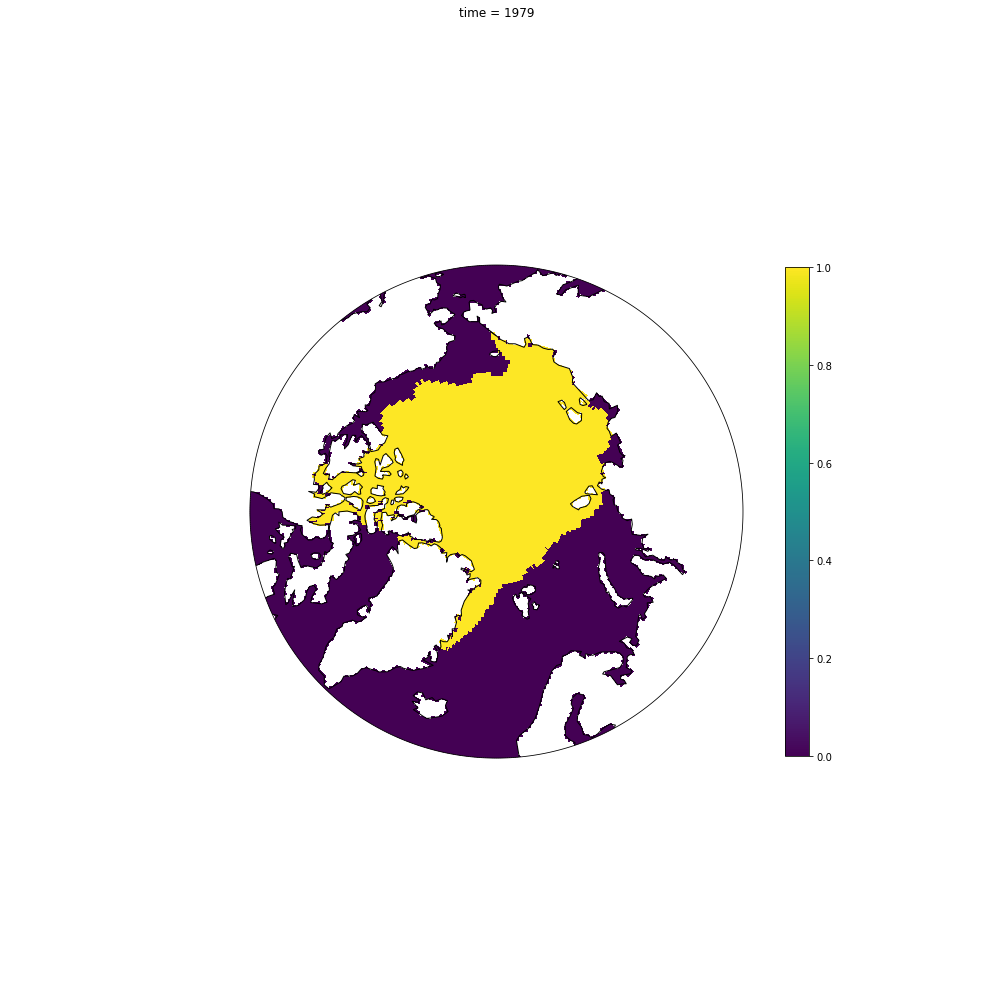

In [10]:
r_limit = 3214068.5
fig = plt.figure(figsize=[18,18])

ax=fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
im = SI_sat.siconc.isel(time=0)[:,:].plot(ax=ax,transform=ccrs.PlateCarree(), x="lon", y="lat")#,  levels = np.linspace(0, 15.0, 2))#, cmap='Reds_r')

circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,
                           circle_path.codes.copy())

ax.set_boundary(circle_path)
im.colorbar.remove()    
plt.colorbar(im,shrink=0.5, pad=-0.2)

ax.coastlines()

### Everything summed up in a function for easier use:

In [11]:
def grid_sat_data(gridding, SIpolys, arctic_only = False):
    ds = xe.util.grid_global(gridding, gridding).copy()
    ds_in = ds.assign(siconc = lambda x: x.lon*0.0).copy()
    ds_sat = ds_in.expand_dims({"t":years}).copy()

    SIpolys_bigblob = np.zeros_like(SIpolys)

    for i,ww in enumerate(SIpolys):
        bigblob = ww.iloc[[np.argmax((ww.area))]]
        shapes = bigblob

        min_grid_size = float(min(abs(ds_in.lat.diff('lat')).min(), abs(ds_in.lon.diff('lon')).min()))
        #print(f'Minimal grid size [°] of input ds: {min_grid_size:0.3f}, we will simplify to a tolerance of {min_grid_size / 100:0.5f}')

        # Simplify geometries
        shapes_simp = shapes.copy()
        shapes_simp['geometry'] = shapes.simplify(min_grid_size / 100).buffer(0)

        #print('Total number of nodes in the simplified shapes : ', shapes_simp.geometry.apply(count_points).sum())
        assert shapes_simp.buffer(0).is_valid.all()
        #print(" ")
        
        #replace each shape by its simplified shape
        SIpolys_bigblob[i]  = shapes_simp 

    crs_new = ccrs.PlateCarree() #new projection
    crs = ccrs.Orthographic(0, 90)

    crs_proj4 = crs.proj4_init


    SIpolys_bigblob_ext = np.zeros_like(SIpolys)

    for i,SIpoly in enumerate(SIpolys_bigblob):

        v = geopandas.GeoDataFrame(SIpoly, geometry=[Polygon(SIpoly.iloc[0].exterior)], #save as geopandas data frame
                                    crs=SIpoly.crs)

        w = v.to_crs(crs_proj4) #project into Orthographic projection

        #project onto Plate Carée (lat/lon)
        new_geometries = [crs_new.project_geometry(ii, src_crs=crs) for ii in w['geometry'].values]             
        
        #save as geopandas data frame
        ww = geopandas.GeoDataFrame(w, geometry=new_geometries, crs=crs_new.proj4_init)
    
        SIpolys_bigblob_ext[i] = ww

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    arctic = world.query('name in ["Greenland","Canada", "Russia", "United States of America", "Iceland", "Norway", "Finland", "Sweden", "Denmark", "United Kingdom", "Ireland" ]' )
    
    if arctic_only:
        landmasses = arctic
    else:
        landmasses = world

    filename_fine = "SI_sat_{}_deg.nc".format(gridding)

    if os.path.exists(filename_fine):
        print("open existing data")
        SI_sat = xr.open_dataset(filename_fine)
    else:
        print('create the dataset')
        SI = ds_sat.siconc.data.copy()

        for i,la in enumerate(ds_sat.lat[:,0].data): #all ### 
            for j,lo in enumerate(ds_sat.lon[0,:].data): ### 
                for k,s in enumerate(SIpolys_bigblob_ext): 
                    if Point(lo,la).within(s["geometry"].values[0]):
                        SI[k,i,j] = 1
                for land in landmasses["geometry"].values:
                    if Point(lo,la).within(land):
                        SI[:,i,j] = np.nan


        SI_sat =  xr.Dataset(data_vars = dict(
                                    siconc = (["time", "lat", "lon"],SI.data)),
                                coords = dict(
                                    time = years,
                                    lat = ds_sat.lat[:,0].data,
                                    lon = ds_sat.lon[0,:].data
                                ))
        #save as netcdf:
        SI_sat.to_netcdf(filename_fine)
    return SI_sat


### Apply the function to get a 1.5 degree gridding

In [16]:
SI_sat_coarse = grid_sat_data(1.5, SIpolys, arctic_only=False)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


open existing data


plot:

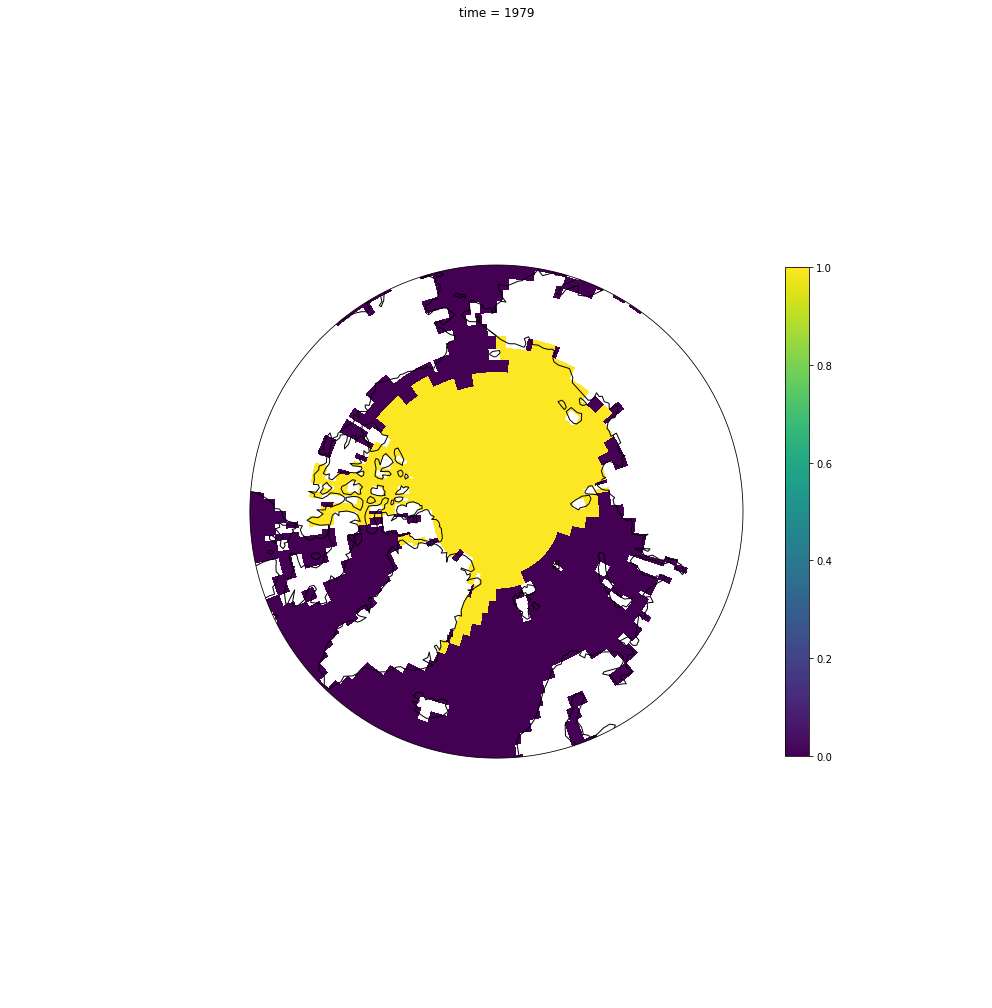

In [17]:
r_limit = 3214068.5
fig = plt.figure(figsize=[18,18])

ax=fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
im = SI_sat_coarse.siconc.isel(time=0)[:,:].plot(ax=ax,transform=ccrs.PlateCarree(), x="lon", y="lat")#,  levels = np.linspace(0, 15.0, 2))#, cmap='Reds_r')

circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,
                           circle_path.codes.copy())

ax.set_boundary(circle_path)
im.colorbar.remove()    
plt.colorbar(im,shrink=0.5, pad=-0.2)

ax.coastlines()

## regrid 0.5 deg gridding of sat data to 1.5 (to have the same grid as used for the regridded CMIP6 models)

In [14]:
filename_coarse = "SI_sat_1.5_deg_from_{}_deg.nc".format(gridding)
if os.path.exists(filename_coarse):
    print("open existing data")
    SI_sat_coarse = xr.open_dataset(filename_coarse)
else:
    print("create the data set")
    ds_data = xr.open_dataset("cdo_regridded_1_5_deg_MPI-ESM1-2-HR")
    sat_fine = SI_sat#xr.open_dataset("satellite_siconc")
    target_grid = ds_data.isel(time=0)
    regridder = xe.Regridder(sat_fine, target_grid, 'bilinear', periodic=True)
    SI_sat_coarse = regridder(sat_fine)
    #save to netcdf
    SI_sat_coarse.to_netcdf(filename_coarse)

open existing data


plot (for one example), 

note: not 0/1 anymore, and there are no "holes" :)

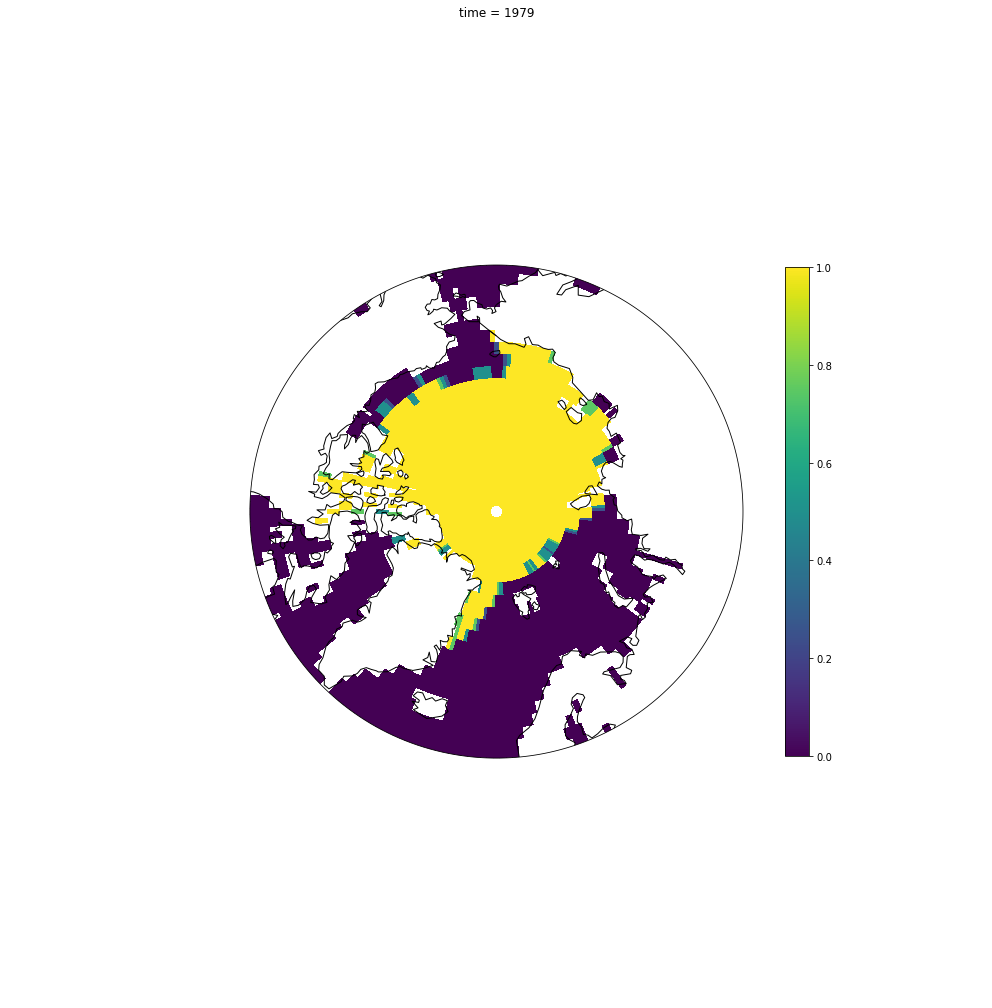

In [15]:
r_limit = 3214068.5

fig = plt.figure(figsize=[18,18])
ax=fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
im = SI_sat_coarse .siconc.isel(time=0)[:,:].plot(ax=ax,transform=ccrs.PlateCarree(), x="lon", y="lat")#,  levels = np.linspace(0, 15.0, 2))#, cmap='Reds_r')

circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,
                           circle_path.codes.copy())
ax.set_boundary(circle_path)
im.colorbar.remove()    
plt.colorbar(im,shrink=0.5, pad=-0.2)

ax.coastlines()